In [40]:
import matplotlib
import matplotlib.colors as col

matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import random as RD
import scipy as SP

cpool = ['#ffffff', '#236d28', '#f44242', '#000000']
cmap3 = col.ListedColormap(cpool, 'indexed')

import csv

RD.seed()

# Get temperatures for Cortez, Colorado in 2017
avg_temps = []
with open('CRND0103-2017-CO_Cortez_8_SE.txt', 'r') as f:
    content = f.readlines()
    for x in content:
        row = x.split()
        avg_temps.append(float(row[7]))

width = 100
height = 100
treeProb = 0.6
beetleProb = 0.05
drought_probability = 0.05
transport_probability = 0.0
empty, tree, infested, dead = range(4)
running_data = {empty:0,tree:0,infested:0,dead:0}

/Users/ben-imadali/anaconda2/envs/py3k/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [41]:
def init():
    global day, config, nextConfig, consecutive_summer_days, drought, cold_snap

    day, consecutive_summer_days = 0, 0
    drought = False
    cold_snap = False

    config = SP.zeros([height, width])
    for x in range(width):
        for y in range(height):
            if RD.random() < treeProb:
                state = tree
            elif RD.random() < beetleProb:
                state = infested
            else:
                state = empty
            config[y, x] = state

    nextConfig = SP.zeros([height, width])

init()

In [42]:
def step():
    global day, config, nextConfig, consecutive_summer_days, drought, cold_snap

    day += 1
    temp = RD.gauss(avg_temps[day%365],1)

    movement_probability = 0
    infestation_probability = 0

    # keep track of the consecutive summer days
    if temp > 20:
        consecutive_summer_days += 1
    else:
        consecutive_summer_days = 0

    # set movement and infestation probability based on consecutive summer days
    if consecutive_summer_days >= 120:
        movement_probability = 0.7
        infestation_probability = 1
    elif consecutive_summer_days < 120 and consecutive_summer_days >= 75:
        movement_probability = 0.4
        infestation_probability = 0.5
    elif consecutive_summer_days < 75 and consecutive_summer_days >= 30:
        movement_probability = 0.2
        infestation_probability = 0.2
    elif consecutive_summer_days < 30:
        movement_probability = 0.05
        infestation_probability = 0.05

    # start, sustain, or end drought
    if drought:
        if RD.random() < 0.3: drought = False
        infestation_probability *= 1.1
        movement_probability *= 1.2
    else:
        if RD.random() < drought_probability:
            drought = True

    threshold_temperature = 0
    # check for cold snap
    threshold_temperature = -40 if day%365 <= 60 and day%365 > 300 else -20

    if temp < threshold_temperature:
        cold_snap = True
    else:
        cold_snap = False

    for x in range(width):
        for y in range(height):
            state = config[y, x]
            if state == infested:
                if cold_snap and RD.random() < 0.9:
                    state = dead

                if RD.random() < 0.995: state = infested
                else:
                    state = dead
            elif state == tree:
                if RD.random() < transport_probability/100:
                    state = infested
                else:
                    for dx in range(-1, 1):
                        for dy in range(-1, 1):
                            # check if the beetles move. if they do, check if they successfully infest a tree
                            if RD.random() < movement_probability:
                                if config[(y+dy)%height, (x+dx)%width] == infested and RD.random() < infestation_probability:
                                    state = infested
                            else: pass

            nextConfig[y, x] = state

    config, nextConfig = nextConfig, config

In [43]:
def draw():
    plt.cla()
    plt.pcolor(config, vmin = 0, vmax = 3, cmap = cmap3)
    plt.title('days = {day}, temperature = {temp:.2f}ºC'.format(day=day, temp=avg_temps[day%365]))
    plt.axis('scaled')
    plt.show()

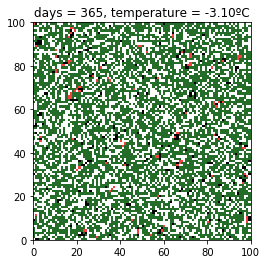

In [46]:
%matplotlib inline
health_values = []


for i in range(10):
    running_data = {empty:0,tree:0,infested:0,dead:0}
    init()

    for day in range(365):
        step()
    for row in config:
        for column in row:
            running_data[column] += 1
    forest_health = running_data[tree]/(running_data[tree]+running_data[infested]+running_data[dead])
    health_values.append(forest_health)
    draw()


In [48]:
# Calculate confidence intervals

import numpy as np
vals = sorted(health_values)
conf_int = [vals[int(0.025*len(vals))],vals[int(0.975*len(vals))]]
print(conf_int)
print(np.mean(vals))

[0.9436413837908072, 0.9436413837908072]
0.943641383791
